I will implement a program to draw trend lines with longer temrs.

In [1]:
# generic
%matplotlib inline
from __future__ import print_function

# common
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# local
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter
from tseries.indicators import get_functions

# for testing purpose
from IPython import display
import platform
#import plotly
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import tqdm
import time
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

def list_packages_versions():
    !date
    print("\ncompiler    : %s"%platform.python_compiler())
    l = platform.linux_distribution()
    print("system      : %s, %s, %s, %s"%(platform.system(),platform.release(),l[0],l[1]))
    print("processor   : %s, %s\n"%(platform.processor(),platform.architecture()[0]))
    
    a = %who_ls module
    for i in a:
        try:
            print("%s %s"%(("%s (%s) "%(globals()[i].__name__,i)).ljust(20,'_'),globals()[i].__version__))
        except:
            pass
list_packages_versions()

Wed Jun 29 04:55:13 UTC 2016

compiler    : GCC 4.8.2
system      : Linux, 3.19.0-51-generic, Ubuntu, 14.04
processor   : x86_64, 64bit

json (json) ________ 2.0.9
numpy (np) _________ 1.11.1
pandas (pd) ________ 0.18.1
platform (platform)  1.0.7
seaborn (sns) ______ 0.7.1


In [2]:
parse_datetime = tm.T.parser("%Y%m%d%H%M")
reference_score = compare.load_reference(parse_json(load_json("/project/exp/reference/downtrend_2015test_1a.json")),
                                         "EURUSD", "5Min", parse_datetime("201501010000"),
                                         parse_datetime("201601010000"))

h5 = histdata.get_pandadb()
symbol="EURJPY"
timeframe="5Min"
df = h5[histdata.get_table_name(symbol, timeframe)]

beginning, end = "2015-01-02 08:00:00" , "2015-05-29 21:55:00"
ref = reference_score[beginning : end]
df = df[beginning : end]

ohlc_data = pd.concat([
        df.iloc[:13704],
        pd.DataFrame({"open":[129.636], "high": [129.589], "low": [129.586], "close": [129.58]},
                     index=[pd.to_datetime("2015-03-10 22:00:00+0000",utc=True)]),
        df.iloc[13704:]    
    ])

def df_to_array(df):
    data_list = []
    for key in df.columns:
        data_list.append(df[key])
    return np.array(data_list)

ohlc_array = df_to_array(ohlc_data)
high_data = np.array(ohlc_data['high'])
low_data = np.array(ohlc_data['low'])
open_data = np.array(ohlc_data["open"])
close_data = np.array(ohlc_data["close"])

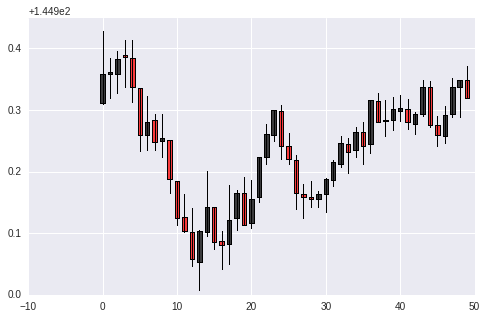

In [3]:
from matplotlib.finance import candlestick2_ohlc

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, ohlc_data["open"][:50], ohlc_data["high"][:50], 
                  ohlc_data["low"][:50], ohlc_data["close"][:50],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

In [4]:
date = ohlc_data.index

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression


def smoothing(data, dim, sig_ob=1.0, sig_sys=1.0e-1):
    """Get smoothed data by trend model with dimension=dim

    matrix for state space model used in this model as follows
    x = Fx + Gv
    y  = Hx + w
    we use Q, R as variance matrix for v, w respectively

    Args:
        data (List(float)): timeseries data
        dim (int): the dimension of the trend model
        sig_ob (float): deviation of noise in observation
        sig_sys (float): deviation of nosie in hiddenvariable

    Return:
        np.array(float): smoothed time series data
    """

    # make data for analysis
    data_list = []
    data_def = np.array(data)
    data_list.append(data_def)
    for i in xrange(dim):
        data_def = data_def[1:] - data_def[:-1]
        data_list.append(data_def)

    # reshape data for available
    N_data = len(data_list[-1])
    for i in xrange(len(data_list)):
        data_list[i] = data_list[i][-N_data:]

    # define state space model parameters
    F = np.tri(dim + 1).T
    G = np.tri(dim + 1).T
    R = sig_ob**2 * np.identity(dim + 1)
    Q = sig_sys**2 * np.identity(dim + 1)
    x_data = np.array(data_list).T

    # filtering step
    V_pred_data = []
    V_filt_data = []
    x_pred_data = []
    x_filt_data = []
    x_filt = x_data[0]
    x_filt_data.append(x_filt)
    V_filt = R
    V_filt_data.append(V_filt)
    for x in iter(x_data[1:]):
        x_pred = np.dot(F, x_filt)
        V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
        kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
        x_filt = x_pred + np.dot(kal_gain, x - x_pred)
        V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
        # store data for smoothing
        x_pred_data.append(x_pred)
        V_pred_data.append(V_pred)
        x_filt_data.append(x_filt)
        V_filt_data.append(V_filt)

    # smoothing step
    N_pred_data = len(V_pred_data)
    x_sm_data = []
    x_sm = x_filt_data[-1]
    x_sm_data.append(x_sm[0])
    V_sm = V_filt_data[-1]
    for i in xrange(N_pred_data):
        idx = N_pred_data - i - 1
        smoother = np.dot(
            V_filt_data[idx],
            np.dot(F.T, np.linalg.inv(V_pred_data[idx]))
        )
        x_sm = x_filt_data[idx]\
            + np.dot(smoother, x_sm - x_pred_data[idx])
        V_sm = V_filt_data[idx]\
            + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
        x_sm_data.append(x_sm[0])

    x_sm_data.reverse()
    # insert raw data to value at t=0, 1, ..., dim-1
    x_sm_data = np.r_[data[range(dim)], x_sm_data]

    return x_sm_data


def get_max_idx(data, is_high=True, window=1, sig_ob=1.0, sig_sys=1.0e-1):
    """Get the index of local max point

    Args:
        data (list): time series data
        is_high (boolean):
            flag to identify weather data is high_data or lowdata
        window (int): the size of forward and backward points
            when determining local maxmum
        sig_ob (float): deviation of noise in observation
        sig_sys (float): deviation of nosie in hidden variabe

    Return:
        List(int): index for local maximum(minimum) for high data(low data)
    """

    data_tilde = np.array(data)
    if is_high is not True:
        data_tilde = -data_tilde
    T = len(data_tilde)

    # regularize data by getting rid of trend of data
    reg = LinearRegression()
    time_data = np.arange(T)
    x = time_data.reshape(T, 1)
    y = np.array(data_tilde).reshape(T, 1)
    reg.fit(x, y)
    coef = reg.coef_[0][0]
    reg_data = data_tilde - coef * time_data

    # data for first order derivative
    def_data = reg_data[1:] - reg_data[:-1]

    # find local optimum point
    idx_max = []
    for i in xrange(1, T - 1):
        if def_data[i] <= 0 and def_data[i - 1] >= 0:
            idx_max.append(i)

    # determine weahter selected points are local maximum
    # in their more global neighbor
    new_idx_max = []
    for idx in iter(idx_max):
        flag = True
        max_value = reg_data[idx]
        for slide in xrange(1, window + 1):
            slide_idx = idx + slide
            if slide_idx > T - 1:
                break
            if max_value < reg_data[slide_idx]:
                flag = False
                break

        for slide in xrange(1, window + 1):
            slide_idx = idx - slide
            if slide_idx < 0:
                break
            if max_value < reg_data[slide_idx]:
                flag = False
                break
        if flag:
            new_idx_max.append(idx)

    return new_idx_max


def get_opt_incpt(x_data, y_data, coef, conf_lev=1, is_high=True):
    """Get line data which has coef and goes over only conf_lev number y_data

    Args:
        x_data (List(int)): index data of y_data
        y_data (List(float)): time series data
        coef (float): coefficient of line data
        conf_lev (int): This number points are allowed to go below line
        is_high (boolean): flag for weather data is high data or low data

    Return:
        float: line's intercept value
    """

    # conf_lev is the number of points
    # to judge validity of support and resistance
    assert len(x_data) >= 1 and len(y_data) >= 1, "you should input some data"

    # for the case of resistance
    if is_high is not True:
        y_data = (-1) * y_data
        coef = -coef

    # generate line data and check how much points cross that line
    N_data = len(x_data)
    for i in xrange(N_data):
        x = x_data[i]
        y = y_data[i]
        incpt = y - coef * x
        line_data = coef * x_data + incpt
        over_flag = 0
        for j in xrange(N_data):
            if i == j:
                continue
            if y_data[j] > line_data[j]:
                over_flag += 1
        if over_flag == conf_lev - 1:
            opt_incpt = incpt
            break

    if is_high is not True:
        opt_incpt = -opt_incpt

    return opt_incpt


def opt_line(data, is_high=True, window=1, sig_ob=1.0, sig_sys=1.0e-1):
    """Get the slope and intercept of optimal line as support or resistance

    Args:
        data (List(float)): time series data
        is_high (boolean): flag for weather data is high data or low data
        window (int): the number of points when choosing local maximal

    Return:
        coef (float): slope of line
        incpt (float): intercept of line
    """

    data = np.array(data)
    max_idx = get_max_idx(data, is_high=is_high)
    N_data = len(data)
    time_data = np.arange(N_data)

    # if you have less than two maximal points, 
    # you wil fail in drawing lines with only maximal points
    if len(max_idx) == 1:
        y = data
        x = time_data
    else:
        y = data[new_max_idx]
        x = time_data[new_max_idx]
        
    reg_y = y.reshape(len(y), 1)
    reg_x = x.reshape(len(x), 1)
    reg = LinearRegression()
    reg.fit(reg_x, reg_y)
    coef = reg.coef_[0][0]
    incpt = get_opt_incpt(
        x_data=x, y_data=y,
        coef=coef, conf_lev=1,
        is_high=is_high)

    return coef, incpt

In [6]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import text

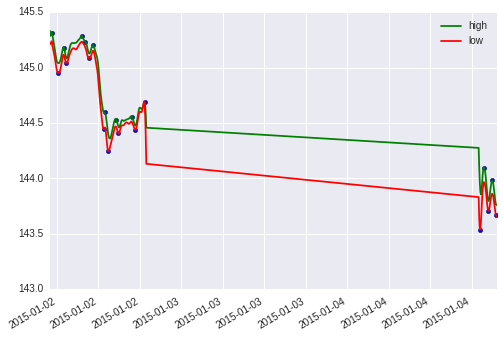

In [7]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

ax.scatter(date_mini[high_idx], smoothed_high[high_idx], c='b')
ax.scatter(date_mini[low_idx], smoothed_low[low_idx], c='b')

ax.plot(date_mini, smoothed_high, label="high", c="g")
ax.plot(date_mini, smoothed_low, label="low", c='r')

# settiing format
days      = mdates.AutoDateLocator()  
daysFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
fig.autofmt_xdate()
plt.xlim(date_mini[0], date_mini[-1])

ax.legend()

It doesn't look nice. I will use graph without time index

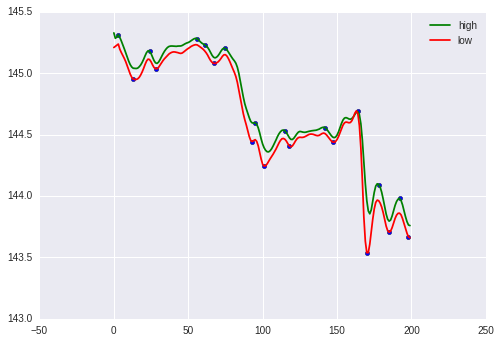

In [27]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='r')

ax.legend()

# Without smoothing

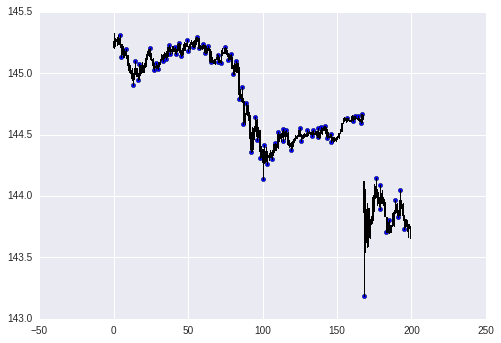

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [28]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# get index of points we use to draw liens
high_idx = get_max_idx(high_data_mini, is_high=True, window=1)
low_idx = get_max_idx(low_data_mini, is_high=False, window=1)

ax.scatter(high_idx, high_data_mini[high_idx], c='b')
ax.scatter(low_idx, low_data_mini[low_idx], c='b')

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

ax.legend()

It looks better to use smoothed data!

I will work on smoothed data.

In [39]:
from sklearn.linear_model import LinearRegression

# get 2 points' indices that will be used for drawing lines
def get_2points(data, is_high=True, window=1):
    # I will take the same approach even for low data
    if is_high is False:
        data = -data
    
    # select poitns among local maximal
    max_idx = get_max_idx(data, is_high=True, window=window)
    x = np.atleast_2d(max_idx).T
    y = np.atleast_2d(data[max_idx]).T
    
    # get rid of trend of whole data
    regr = LinearRegression()
    regr.fit(x, y)
    y_tilde = y - regr.predict(x)
    
    # select 2 points
    y_tilde = y_tilde.ravel()
    x = x.ravel()
    idx = np.argsort(y_tilde)[::-1]
    
    return x[idx[:2]]

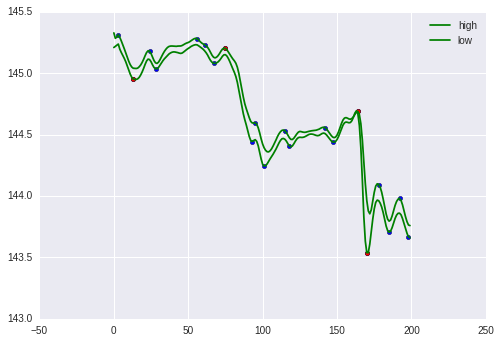

In [40]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

high_2p_idx = get_2points(smoothed_high, is_high=True, window=1)
low_2p_idx = get_2points(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_2p_idx, smoothed_high[high_2p_idx], c='r')
ax.scatter(low_2p_idx, smoothed_low[low_2p_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

# Let's draw trend lines

In [43]:
# given data, return line data, which is as long as the length of data
def draw_line(data, is_high=True):
    # with AR model, smooth data
    smoothed_data = smoothing(data, dim=4)

    # get index of points we use to draw liens
    two_idx = get_2points(smoothed_data, is_high=is_high, window=1)
    
    # make line data
    n_data = len(data)
    x = np.arange(n_data)
    coef = (smoothed_data[two_idx[0]] - smoothed_data[two_idx[1]]) / (two_idx[0] - two_idx[1])
    return coef * (x - two_idx[0]) + smoothed_data[two_idx[0]]

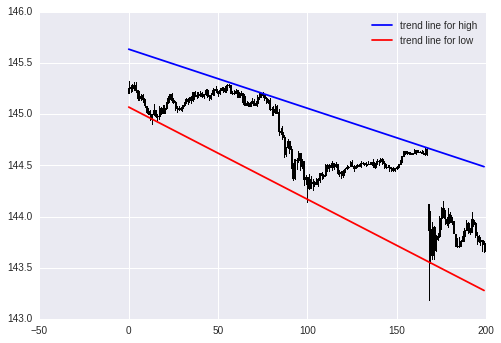

In [48]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line(high_data_mini, is_high=True)
low_trend = draw_line(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

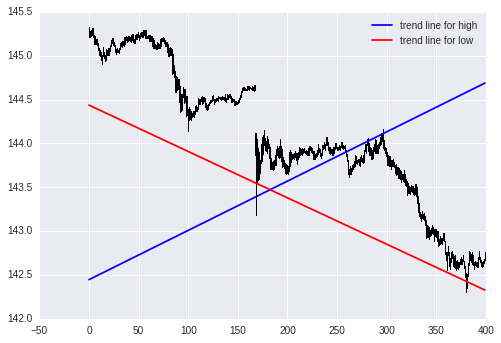

In [49]:
N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line(high_data_mini, is_high=True)
low_trend = draw_line(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

Anything wrong? Let's fix it

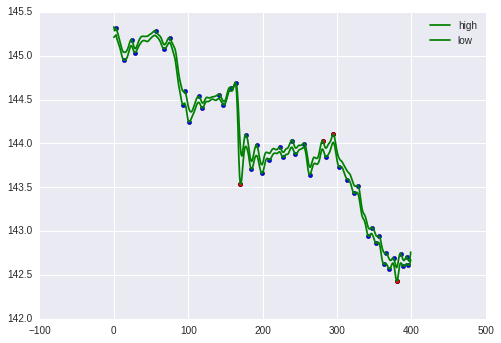

In [50]:
N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

high_2p_idx = get_2points(smoothed_high, is_high=True, window=1)
low_2p_idx = get_2points(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_2p_idx, smoothed_high[high_2p_idx], c='r')
ax.scatter(low_2p_idx, smoothed_low[low_2p_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

Irelevant points affect too much

In [51]:
from sklearn.linear_model import LinearRegression

# get n points' indices that will be used for drawing lines
def select_feature_points(data, is_high=True, n_points=3, window=1):
    # I will take the same approach even for low data
    if is_high is False:
        data = -data
    
    # select poitns among local maximal
    max_idx = get_max_idx(data, is_high=True, window=window)
    x = np.atleast_2d(max_idx).T
    y = np.atleast_2d(data[max_idx]).T
    
    # get rid of trend of whole data
    regr = LinearRegression()
    regr.fit(x, y)
    y_tilde = y - regr.predict(x)
    
    # select 2 points
    y_tilde = y_tilde.ravel()
    x = x.ravel()
    idx = np.argsort(y_tilde)[::-1]
    
    return x[idx[:n_points]]

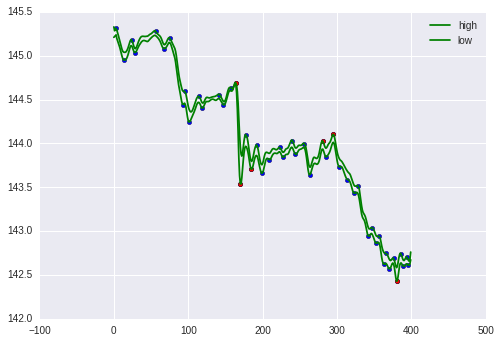

In [53]:
N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

high_feature_idx = select_feature_points(smoothed_high, is_high=True, window=1)
low_feature_idx = select_feature_points(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_feature_idx, smoothed_high[high_feature_idx], c='r')
ax.scatter(low_feature_idx, smoothed_low[low_feature_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

It's bette to select points more carefully.

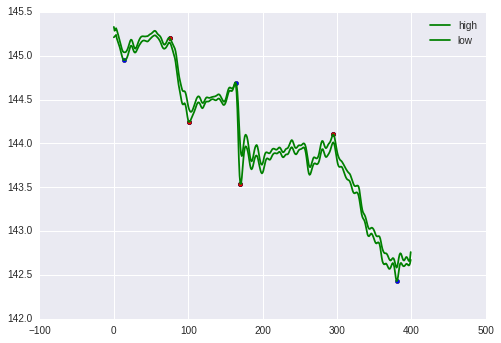

In [56]:
N = 400
M = 0
dim=4

window = int((N - M) / 10)

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=window)
low_idx = get_max_idx(smoothed_low, is_high=False, window=window)

high_2p_idx = get_2points(smoothed_high, is_high=True, window=window)
low_2p_idx = get_2points(smoothed_low, is_high=False, window=window)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_2p_idx, smoothed_high[high_2p_idx], c='r')
ax.scatter(low_2p_idx, smoothed_low[low_2p_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

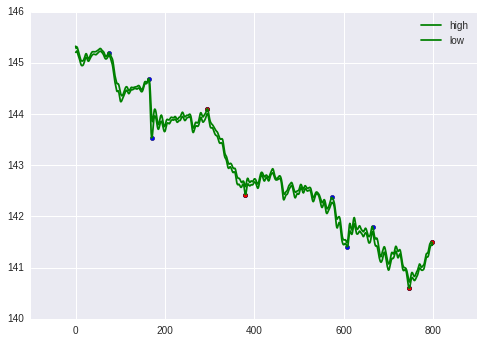

In [57]:
N = 800
M = 0
dim=4

window = int((N - M) / 10)

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=window)
low_idx = get_max_idx(smoothed_low, is_high=False, window=window)

high_2p_idx = get_2points(smoothed_high, is_high=True, window=window)
low_2p_idx = get_2points(smoothed_low, is_high=False, window=window)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_2p_idx, smoothed_high[high_2p_idx], c='r')
ax.scatter(low_2p_idx, smoothed_low[low_2p_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

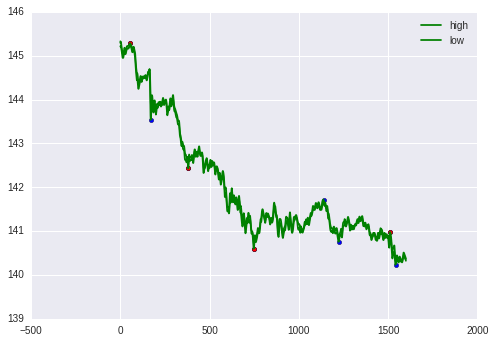

In [58]:
N = 1600
M = 0
dim=4

window = int((N - M) / 10)

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=window)
low_idx = get_max_idx(smoothed_low, is_high=False, window=window)

high_2p_idx = get_2points(smoothed_high, is_high=True, window=window)
low_2p_idx = get_2points(smoothed_low, is_high=False, window=window)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.scatter(high_2p_idx, smoothed_high[high_2p_idx], c='r')
ax.scatter(low_2p_idx, smoothed_low[low_2p_idx], c='r')

ax.plot(smoothed_high, label="high", c="g")
ax.plot(smoothed_low, label="low", c='g')

ax.legend()

In [94]:
# given data, return line data, which is as long as the length of data
def draw_line2(data, is_high=True):
    
    if is_high is False:
        data = -data
        
    # with AR model, smooth data
    smoothed_data = smoothing(data, dim=4)

    # get index of points we use to draw liens
    n_data = len(data)
    n_seperate = 10
    window = int(n_data / n_seperate)
    while True:
        if window < 1:
            window = 1
        max_idx = get_max_idx(smoothed_data, is_high=True, window=window)
        # iterate this process until getting enough number of points
        if len(max_idx) >= 2:
            break
        # stop iteration if we cannot chop data into small pecies
        if window == 1:
            break
        window = int(0.5 * window)
    
    x = np.atleast_2d(max_idx).T
    y = np.atleast_2d(smoothed_data[max_idx]).T
    
    # get rid of trend of whole data
    regr = LinearRegression()
    regr.fit(x, y)
    y_tilde = y - regr.predict(x)
    
    # select 2 points
    y_tilde = y_tilde.ravel()
    x = x.ravel()
    idx = np.argsort(y_tilde)[::-1]
    two_idx = x[idx[:2]]
    
    if is_high is False:
        smoothed_data = -smoothed_data
    
    # make line data
    x = np.arange(n_data)
    coef = (smoothed_data[two_idx[0]] - smoothed_data[two_idx[1]]) / (two_idx[0] - two_idx[1])
    return coef * (x - two_idx[0]) + smoothed_data[two_idx[0]]

3
4


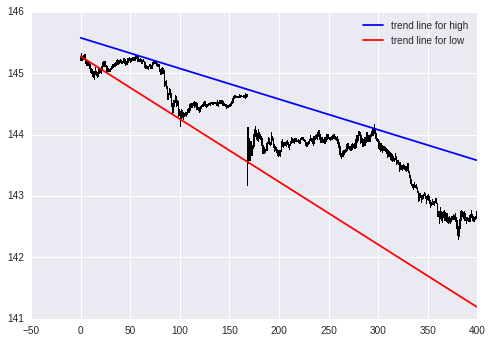

In [70]:
N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

6
4


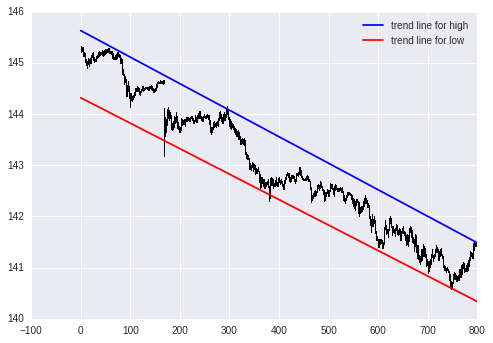

In [71]:
N = 800
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

3
5


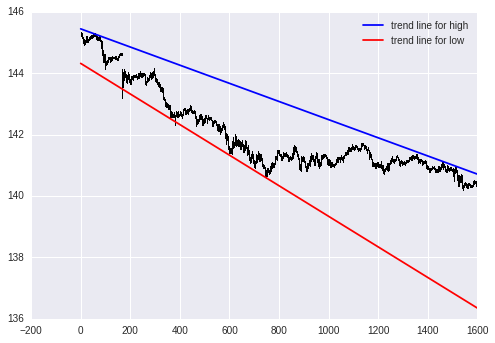

In [72]:
N = 1600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

2
3


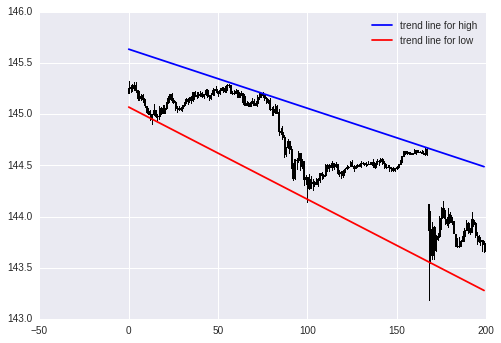

In [73]:
N = 200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

4
2


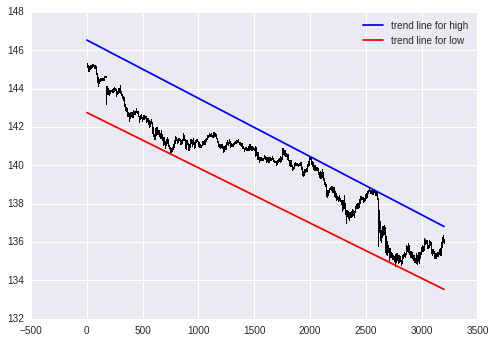

In [75]:
N = 3200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

3
3


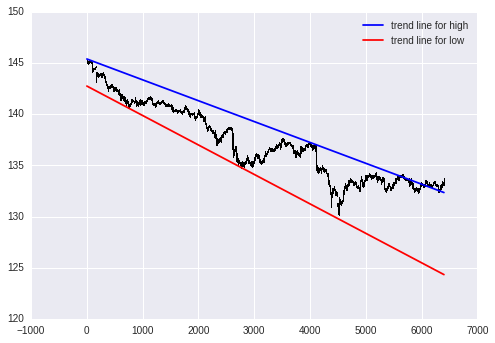

In [76]:
N = 6400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

5
4


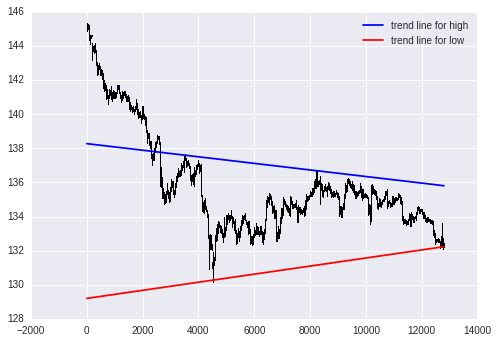

In [77]:
N = 12800
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

3
3


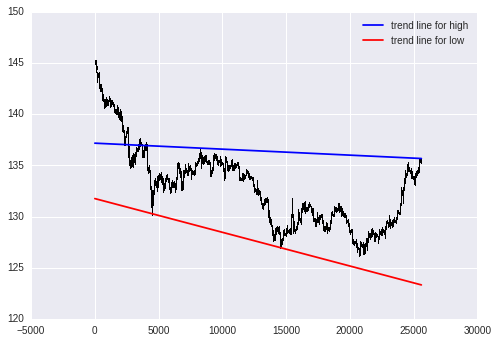

In [78]:
N = 25600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = draw_line2(high_data_mini, is_high=True)
low_trend = draw_line2(low_data_mini, is_high=False)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, label='trend line for high', c='b')
ax.plot(low_trend, label='trend line for low', c='r')

ax.legend()

# draw several lines

seperate data into a few subsets, then judge weather to draw a new line based on these subsets.

In [143]:
def get_sepearted_trendline(data, is_high=True, n_seperate=5, tolerance=0.2):
    """Get sperated trendline data
    
    Args:
        data(numpy.array): stock data
        is_high(bool): when True, data is high data
                                when False, data is low data
        n_seprates(int): the number of subsets you split data into
        tolearance(float): the tolearance ration of data going
                                            over trendlines
                                            
    Return
        line_data(List(np.array)): trendline data
        index_data(List(np.array)): index of line data
    """
    
    line_data = []
    index_data = []
    n_data = len(data)
    # index for data
    index = np.arange(n_data)
    
    # make a trendline on each seperated data
    split_data = np.array_split(data, n_seperate, axis=0)
    split_idx = np.array_split(index, n_seperate, axis=0)
    for idx in xrange(len(split_data)):
        sub_d = split_data[idx]
        sub_idx = split_idx[idx]
        
        if idx >= 1:
            # the number to allow to go over lines
            n_tolerance = int(len(sub_d) * tolerance) 
            coef = (pre_trendline[-1] - pre_trendline[0]) / len(pre_trendline)
            extended_line = coef * np.arange(1, len(sub_d) + 1) + pre_trendline[-1]
            over_idx = np.where(extended_line < sub_d)[0]
            # if data go over line too much, make a new line
            # else combined new data with previous data
            if len(over_idx) > n_tolerance:
                line_data.append(pre_trendline)
                index_data.append(pre_idx)
                print ("break the line")
            else:
                sub_d = np.r_[pre_d, sub_d]
                sub_idx = np.r_[pre_idx, sub_idx]
                
        pre_trendline = draw_line2(sub_d, is_high=is_high)
        pre_d = sub_d
        pre_idx = sub_idx
        
    line_data.append(pre_trendline)
    index_data.append(pre_idx)
    return line_data, index_data

break the line
break the line
break the line
break the line
break the line


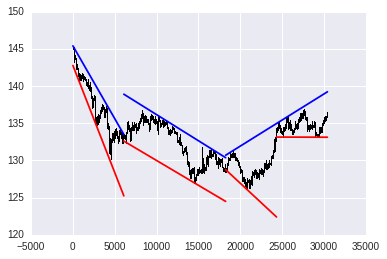

In [149]:
from itertools import izip

N = 51200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline(high_data_mini, is_high=True, n_seperate=5)
low_trend, low_idx = get_sepearted_trendline(low_data_mini, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

break the line
break the line


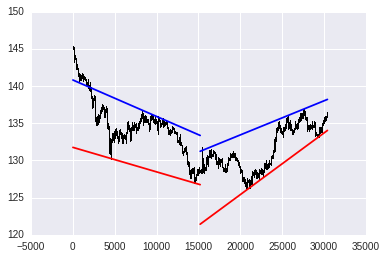

In [145]:
from itertools import izip

N = 51200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline(high_data_mini, is_high=True, n_seperate=2)
low_trend, low_idx = get_sepearted_trendline(low_data_mini, is_high=False, n_seperate=2)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

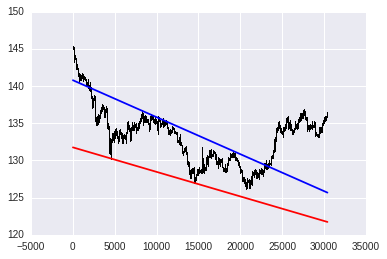

In [146]:
from itertools import izip

N = 51200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline(high_data_mini, is_high=True, n_seperate=1)
low_trend, low_idx = get_sepearted_trendline(low_data_mini, is_high=False, n_seperate=1)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

# draw lines backward

In [155]:
def get_sepearted_trendline2(data, is_high=True, n_seperate=5, tolerance=0.1):
    """Get sperated trendline data
    
    Args:
        data(numpy.array): stock data
        is_high(bool): when True, data is high data
                                when False, data is low data
        n_seprates(int): the number of subsets you split data into
        tolearance(float): the tolearance ration of data going
                                            over trendlines
                                            
    Return
        line_data(List(np.array)): trendline data
        index_data(List(np.array)): index of line data
    """
    
    line_data = []
    index_data = []
    n_data = len(data)
    # index for data
    index = np.arange(n_data)
    
    # make a trendline on each seperated data
    split_data = np.array_split(data, n_seperate, axis=0)[::-1]
    split_idx = np.array_split(index, n_seperate, axis=0)[::-1]
    for idx in xrange(len(split_data)):
        sub_d = split_data[idx]
        sub_idx = split_idx[idx]
        
        line_flag = True
        if idx >= 1:
            # the number to allow to go over lines
            n_tolerance = int(len(sub_d) * tolerance) 
            coef = (pre_trendline[-1] - pre_trendline[0]) / len(pre_trendline)
            extended_line = -coef * np.arange(1, len(sub_d) + 1)[::-1] + pre_trendline[0]
            over_idx = np.where(extended_line < sub_d)[0]
            # if data go over line too much, make a new line
            # else combined new data with previous data
            if len(over_idx) > n_tolerance:
                # careful: if you want to use more than 2 n_seperate,
                # you have to modify here; draw line using all of the data
                line_data.append(np.r_[extended_line, pre_trendline])
                index_data.append(np.r_[sub_idx, pre_idx])
                print ("break the line")
                line_flag = False
                break 
            else:
                sub_d = np.r_[sub_d, pre_d]
                sub_idx = np.r_[sub_idx, pre_idx]
                
        pre_trendline = draw_line2(sub_d, is_high=is_high)
        pre_d = sub_d
        pre_idx = sub_idx
      
    if line_flag is True:
        line_data.append(pre_trendline)
        index_data.append(pre_idx)
    return line_data, index_data

break the line
break the line


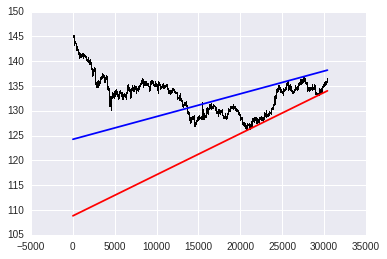

In [151]:
from itertools import izip

N = 51200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline2(high_data_mini, is_high=True, n_seperate=2)
low_trend, low_idx = get_sepearted_trendline2(low_data_mini, is_high=False, n_seperate=2)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

Backward drawing looks nice.

break the line
break the line


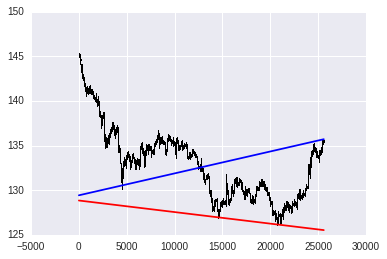

In [152]:
from itertools import izip

N = 25600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline2(high_data_mini, is_high=True, n_seperate=2)
low_trend, low_idx = get_sepearted_trendline2(low_data_mini, is_high=False, n_seperate=2)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

break the line


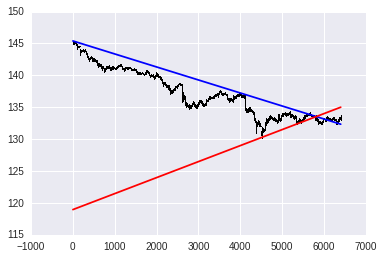

In [156]:
from itertools import izip

N = 6400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline2(high_data_mini, is_high=True, n_seperate=2)
low_trend, low_idx = get_sepearted_trendline2(low_data_mini, is_high=False, n_seperate=2)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

break the line
break the line


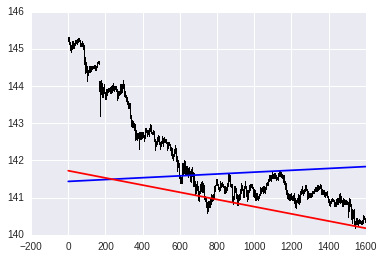

In [157]:
from itertools import izip

N = 1600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend, high_idx = get_sepearted_trendline2(high_data_mini, is_high=True, n_seperate=2)
low_trend, low_idx = get_sepearted_trendline2(low_data_mini, is_high=False, n_seperate=2)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

for idx, data in izip(high_idx, high_trend):
    ax.plot(idx, data, c='b')
    
for idx, data in zip(low_idx, low_trend):
    ax.plot(idx, data, c='r')

ax.legend()

We need modification!

I will implement algorithm to pick up points from various places.

In [195]:
def regularized_data(x, y):
    x_tilde = np.atleast_2d(x).T
    y_tilde = np.atleast_2d(y).T
    regr = LinearRegression()
    regr.fit(x_tilde, y_tilde)
    y_tilde = y_tilde - regr.predict(x_tilde)
    return y_tilde.ravel()

def regularized_param(x, y):
    x_tilde = np.atleast_2d(x).T
    y_tilde = np.atleast_2d(y).T
    regr = LinearRegression()
    regr.fit(x_tilde, y_tilde)
    return regr.coef_[0][0], regr.intercept_[0]

In [348]:
def get_locmax_idx(y):
    # data of first order derivative
    def_data = y[1:] - y[:-1]

    # find local optimum point
    T = len(def_data)
    idx_list = []
    
    # local maximum
    for i in xrange(1, T):
        if def_data[i] <= 0 and def_data[i - 1] >= 0:
            idx_list.append(i)

    return idx_list
    
    
# pick up a point from each subset [xi, yi] for drawing line
# then, return parameters of trendlines
def get_line_param(x1, x2, y1, y2, is_high=True):
    
    if is_high is False:
        y1 = -y1
        y2 = -y2
        
    x = np.r_[x1, x2]
    y = np.r_[y1, y2]
    
    # get regularized data and localmax from each subset respectively
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1 - (coef * x1 + incpt)
    y2_tilde = y2 - (coef * x2 + incpt)
    locmax_idx1 = get_locmax_idx(y1_tilde)
    locmax_idx2 = get_locmax_idx(y2_tilde)
    
    # select two points for trend line
    x1_line = x1[locmax_idx1]
    x2_line = x2[locmax_idx2]
    y1_line = y1[locmax_idx1]
    y2_line = y2[locmax_idx2]
    x = np.r_[x1_line, x2_line]
    y = np.r_[y1_line, y2_line]
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1_line - (coef * x1_line + incpt)
    y2_tilde = y2_line - (coef * x2_line + incpt)
    max_idx1= np.argsort(y1_tilde)[-1]
    max_idx2 = np.argsort(y2_tilde)[-1]
    idx1 = locmax_idx1[max_idx1]
    idx2 = locmax_idx2[max_idx2]
    x1_line = x1[idx1]
    x2_line = x2[idx2]
    y1_line = y1[idx1]
    y2_line = y2[idx2]
    
    #compute parameters
    coef = (y1_line - y2_line) / (x1_line - x2_line)
    incpt = y1_line - coef * x1_line
    
    if is_high is False:
        coef = -coef
        incpt = -incpt
        
    return coef, incpt

In [349]:
def trendline_backward(data, is_high=True, n_seperate=10, tolerance=0.1):
    """Get sperated trendline data
    
    Args:
        data(numpy.array): stock data
        is_high(bool): when True, data is high data
                                when False, data is low data
        n_seprates(int): the number of subsets you split data into
        tolearance(float): the tolearance ratio of data going
                                       over trendlines
                                            
    Return
        line_data(List(np.array)): trendline data
    """
    
    if is_high is False:
        data = -data
    
    n_data = len(data)
    # index for data
    index = np.arange(n_data)
    
    # make a trendline on each seperated data
    split_data = np.array_split(data, n_seperate, axis=0)[::-1]
    split_idx = np.array_split(index, n_seperate, axis=0)[::-1]
    # use the latest grid and the other grid to draw lines
    sub_d0 = split_data[0]
    sub_idx0 = split_idx[0]
    
    # make line data
    x = np.r_[split_idx[1], sub_idx0]
    y = np.r_[split_data[1], sub_d0]
    coef, incpt = get_line_param(sub_idx0, split_idx[1], sub_d0, split_data[1], is_high=True)
    line_data = coef * index + incpt
    
    for idx in xrange(2, len(split_data)):
        sub_d = split_data[idx]
        sub_idx = split_idx[idx]
        x = np.r_[sub_idx, sub_idx0]
        y = np.r_[sub_d, sub_d0]
        
        # check weather line is broken
        sub_line = coef * x + incpt
        over_idx = np.where(sub_line < y)[0]
        # if data go over line too much, make a new line
        n_tolerance = int(n_data * tolerance / n_seperate)
        if len(over_idx) >= n_tolerance:
            # make line data
            coef, incpt = get_line_param(sub_idx0, sub_idx, sub_d0, sub_d, is_high=True) 
            line_data = coef * index + incpt
            print ("break the line", is_high)
    
    if is_high is False:
        line_data = -line_data
    return line_data

break the line True
break the line False


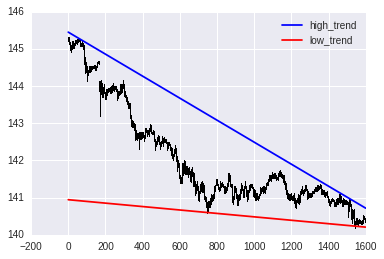

In [350]:
from itertools import izip

N = 1600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

ax.legend()

break the line True
break the line True
break the line False


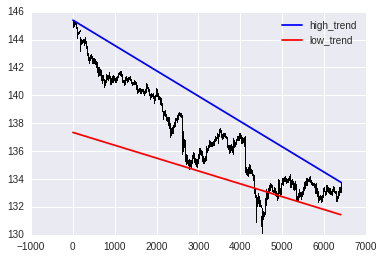

In [351]:
from itertools import izip

N = 6400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')


ax.legend()

break the line True
break the line True
break the line True
break the line False


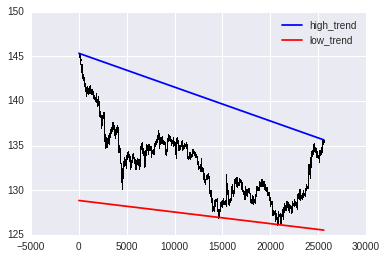

In [352]:
from itertools import izip

N = 25600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')

ax.legend()

break the line True
break the line True
break the line True


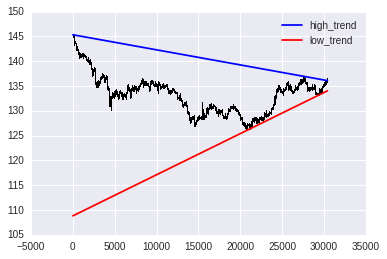

In [353]:
from itertools import izip

N = 51200
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')

ax.legend()

break the line False


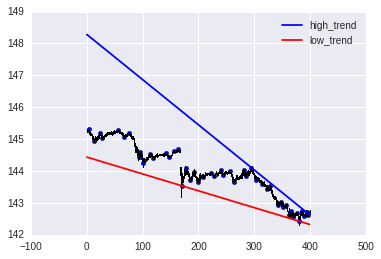

In [346]:
from itertools import izip

N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.legend()

In [311]:
def trendline_backward2(data, is_high=True, n_seperate=10):
    """Get sperated trendline data
    
    Args:
        data(numpy.array): stock data
        is_high(bool): when True, data is high data
                                when False, data is low data
        n_seprates(int): the number of subsets you split data into
        tolearance(float): the tolearance ratio of data going
                                       over trendlines
                                            
    Return
        line_data(List(np.array)): trendline data
    """
    
    if is_high is False:
        data = -data
    
    n_data = len(data)
    # index for data
    index = np.arange(n_data)
    
    # seperate points among local maimal points
    data_tilde = regularized_data(index, data)
    locmax_idx = get_locmax_idx(data_tilde)
    
    # we need more than two points to draw lines
    while len(locmax_idx) < 2 * n_seperate:
        n_seperate = int(0.5 * n_seperate)
        
    # make a trendline on each seperated data
    print (len(locmax_idx))
    split_idx = np.array_split(locmax_idx, n_seperate, axis=0)[::-1]
    
    # use the latest grid and the other grid to draw lines
    sub_idx0 = split_idx[0]
    x0 = index[sub_idx0]
    y0 = data[sub_idx0]
    
    # make line data
    new_x = index[split_idx[1]]
    new_y = index[split_idx[1]]
    coef, incpt = get_line_param2(x0, new_x, y0, new_y, is_high=True)
    line_data = coef * index + incpt
    
    for idx in xrange(2, n_seperate):
        new_idx = split_idx[idx]
        new_x = index[new_idx]
        new_y = data[new_idx]
        x = np.r_[x0, new_x]
        y = np.r_[y0, new_y]
        
        # check weather line is broken
        sub_line = coef * x + incpt
        over_idx = np.where(sub_line < y)[0]
        # if data go over line too much, make a new line
        if len(over_idx) >= 1:
            # make line data
            coef, incpt = get_line_param2(x0, new_x, y0, new_y, is_high=True)
            line_data = coef * index + incpt
    
    if is_high is False:
        line_data = -line_data
    return line_data

In [312]:
def get_locmax_idx(y):
    # data of first order derivative
    def_data = y[1:] - y[:-1]

    # find local optimum point
    T = len(def_data)
    idx_list = []
    for i in xrange(1, T):
        if def_data[i] <= 0 and def_data[i - 1] >= 0:
            idx_list.append(i)

    return idx_list
    
    
# pick up a point from each subset [xi, yi] for drawing line
# then, return parameters of trendlines
def get_line_param2(x1, x2, y1, y2, is_high=True):
    
    if is_high is False:
        y1 = -y1
        y2 = -y2
    
    # select two points for trend line
    x = np.r_[x1, x2]
    y = np.r_[y1, y2]
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1 - (coef * x1 + incpt)
    y2_tilde = y2 - (coef * x2 + incpt)
    idx1= np.argsort(y1_tilde)[-1]
    idx2 = np.argsort(y2_tilde)[-1]
    x1_line = x1[idx1]
    x2_line = x2[idx2]
    y1_line = y1[idx1]
    y2_line = y2[idx2]
    
    #compute parameters
    coef = (y1_line - y2_line) / (x1_line - x2_line)
    incpt = y1_line - coef * x1_line
    
    if is_high is False:
        coef = -coef
        incpt = -incpt
        
    return coef, incpt

23
25


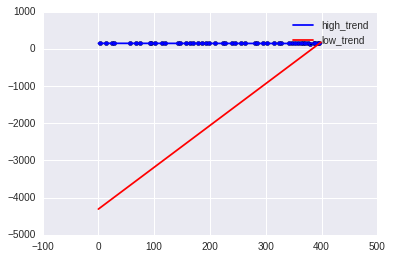

In [313]:
from itertools import izip

N = 400
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
date_mini = date[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

# get trend line data
high_trend = trendline_backward2(smoothed_high, is_high=True, n_seperate=5)
low_trend = trendline_backward2(smoothed_low, is_high=False, n_seperate=5)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')

# get index of points we use to draw liens
high_idx = get_max_idx(smoothed_high, is_high=True, window=1)
low_idx = get_max_idx(smoothed_low, is_high=False, window=1)

ax.scatter(high_idx, smoothed_high[high_idx], c='b')
ax.scatter(low_idx, smoothed_low[low_idx], c='b')

ax.legend()

In [297]:
def get_locmax_idx(y):
    # data of first order derivative
    def_data = y[1:] - y[:-1]

    # find local optimum point
    T = len(def_data)
    idx_list = []
    for i in xrange(1, T):
        if def_data[i] <= 0 and def_data[i - 1] >= 0:
            idx_list.append(i)

    return idx_list
    
    
# pick up a point from each subset [xi, yi] for drawing line
# then, return parameters of trendlines
def get_line_param2(x1, x2, y1, y2, is_high=True):
    
    if is_high is False:
        y1 = -y1
        y2 = -y2
    
    # select two points for trend line
    x = np.r_[x1, x2]
    y = np.r_[y1, y2]
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1 - (coef * x1 + incpt)
    y2_tilde = y2 - (coef * x2 + incpt)
    idx1= np.argsort(y1_tilde)[-1]
    idx2 = np.argsort(y2_tilde)[-1]
    x1_line = x1[idx1]
    x2_line = x2[idx2]
    y1_line = y1[idx1]
    y2_line = y2[idx2]
    
    #compute parameters
    coef = (y1_line - y2_line) / (x1_line - x2_line)
    incpt = y1_line - coef * x1_line
    
    if is_high is False:
        coef = -coef
        incpt = -incpt
        
    return coef, incpt

trendline_backward looks better than trendline_backward2

# Let's make trendline.py

In [378]:
import numpy as np
from sklearn.linear_model import LinearRegression


def smoothing(data, dim, sig_ob=1.0, sig_sys=1.0e-1):
    """Get smoothed data by trend model with dimension=dim

    matrix for state space model used in this model as follows
    x = Fx + Gv
    y  = Hx + w
    we use Q, R as variance matrix for v, w respectively

    Args:
        data (List(float)): timeseries data
        dim (int): the dimension of the trend model
        sig_ob (float): deviation of noise in observation
        sig_sys (float): deviation of nosie in hiddenvariable

    Return:
        np.array(float): smoothed time series data
    """

    # make data for analysis
    data_list = []
    data_def = np.array(data)
    data_list.append(data_def)
    for i in xrange(dim):
        data_def = data_def[1:] - data_def[:-1]
        data_list.append(data_def)

    # reshape data for available
    N_data = len(data_list[-1])
    for i in xrange(len(data_list)):
        data_list[i] = data_list[i][-N_data:]

    # define state space model parameters
    F = np.tri(dim + 1).T
    G = np.tri(dim + 1).T
    R = sig_ob**2 * np.identity(dim + 1)
    Q = sig_sys**2 * np.identity(dim + 1)
    x_data = np.array(data_list).T

    # filtering step
    V_pred_data = []
    V_filt_data = []
    x_pred_data = []
    x_filt_data = []
    x_filt = x_data[0]
    x_filt_data.append(x_filt)
    V_filt = R
    V_filt_data.append(V_filt)
    for x in iter(x_data[1:]):
        x_pred = np.dot(F, x_filt)
        V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
        kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
        x_filt = x_pred + np.dot(kal_gain, x - x_pred)
        V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
        # store data for smoothing
        x_pred_data.append(x_pred)
        V_pred_data.append(V_pred)
        x_filt_data.append(x_filt)
        V_filt_data.append(V_filt)

    # smoothing step
    N_pred_data = len(V_pred_data)
    x_sm_data = []
    x_sm = x_filt_data[-1]
    x_sm_data.append(x_sm[0])
    V_sm = V_filt_data[-1]
    for i in xrange(N_pred_data):
        idx = N_pred_data - i - 1
        smoother = np.dot(
            V_filt_data[idx],
            np.dot(F.T, np.linalg.inv(V_pred_data[idx]))
        )
        x_sm = x_filt_data[idx]\
            + np.dot(smoother, x_sm - x_pred_data[idx])
        V_sm = V_filt_data[idx]\
            + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
        x_sm_data.append(x_sm[0])

    x_sm_data.reverse()
    # insert raw data to value at t=0, 1, ..., dim-1
    x_sm_data = np.r_[data[range(dim)], x_sm_data]

    return x_sm_data


# get rid of trend of whole data
# and return modified value
def regularized_data(x, y):
    x_tilde = np.atleast_2d(x).T
    y_tilde = np.atleast_2d(y).T
    regr = LinearRegression()
    regr.fit(x_tilde, y_tilde)
    y_tilde = y_tilde - regr.predict(x_tilde)
    return y_tilde.ravel()

# return coefficients and intercept of trend
# of whole data to get rid of it
def regularized_param(x, y):
    x_tilde = np.atleast_2d(x).T
    y_tilde = np.atleast_2d(y).T
    regr = LinearRegression()
    regr.fit(x_tilde, y_tilde)
    return regr.coef_[0][0], regr.intercept_[0]

# return local maximal values' index
# don't take edge values into consideration
def get_locmax_idx(y):
    # data of first order derivative
    def_data = y[1:] - y[:-1]

    # find local optimum point
    T = len(def_data)
    idx_list = []
    
    # local maximum
    for i in xrange(1, T):
        if def_data[i] <= 0 and def_data[i - 1] >= 0:
            idx_list.append(i)

    return idx_list


# pick up a point from each subset [xi, yi] for drawing line
# then, return parameters of trendlines
def get_line_param(x1, x2, y1, y2, is_high=True):
    """Get parameters of trendlines of two subsets

    Args:
        x_1, x_2 (list): index of time series data
        y_1, y_2 (list): time series data
        is_high (boolean):
            flag to identify weather data is high_data or lowdata
        window (int): the size of forward and backward points
            when determining local maxmum

    Return:
        coef (float): coefficient of trendline
        incpt (float): intercept of trendline
    """
    if is_high is False:
        y1 = -y1
        y2 = -y2
        
    x = np.r_[x1, x2]
    y = np.r_[y1, y2]
    
    # get regularized data and localmax from each subset respectively
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1 - (coef * x1 + incpt)
    y2_tilde = y2 - (coef * x2 + incpt)
    locmax_idx1 = get_locmax_idx(y1_tilde)
    locmax_idx2 = get_locmax_idx(y2_tilde)
    
    # select two points for trend line
    x1_line = x1[locmax_idx1]
    x2_line = x2[locmax_idx2]
    y1_line = y1[locmax_idx1]
    y2_line = y2[locmax_idx2]
    x = np.r_[x1_line, x2_line]
    y = np.r_[y1_line, y2_line]
    coef, incpt = regularized_param(x, y)
    y1_tilde = y1_line - (coef * x1_line + incpt)
    y2_tilde = y2_line - (coef * x2_line + incpt)
    max_idx1= np.argsort(y1_tilde)[-1]
    max_idx2 = np.argsort(y2_tilde)[-1]
    idx1 = locmax_idx1[max_idx1]
    idx2 = locmax_idx2[max_idx2]
    x1_line = x1[idx1]
    x2_line = x2[idx2]
    y1_line = y1[idx1]
    y2_line = y2[idx2]
    
    #compute parameters
    coef = (y1_line - y2_line) / (x1_line - x2_line)
    incpt = y1_line - coef * x1_line
    
    if is_high is False:
        coef = -coef
        incpt = -incpt
        
    return coef, incpt

def trendline_backward(data, is_high=True, n_seperate=5, tolerance=0.1):
    """Get trendline data
    
    Args:
        data(numpy.array): stock data
        is_high(bool): when True, data is high data
                                when False, data is low data
        n_seprates(int): the number of subsets you split data into
        tolearance(float): the tolearance ratio of data going
                                       over trendlines
                                            
    Return
        line_data(List(np.array)): trendline data
    """
    
    if is_high is False:
        data = -data
    
    n_data = len(data)
    # index for data
    index = np.arange(n_data)
    
    # make a trendline on each seperated data
    split_data = np.array_split(data, n_seperate, axis=0)[::-1]
    split_idx = np.array_split(index, n_seperate, axis=0)[::-1]
    # use the latest grid and the other grid to draw lines
    sub_d0 = split_data[0]
    sub_idx0 = split_idx[0]
    
    # make line data
    x = np.r_[split_idx[1], sub_idx0]
    y = np.r_[split_data[1], sub_d0]
    coef, incpt = get_line_param(sub_idx0, split_idx[1], sub_d0, split_data[1], is_high=True)
    line_data = coef * index + incpt
    
    for idx in xrange(2, len(split_data)):
        sub_d = split_data[idx]
        sub_idx = split_idx[idx]
        x = np.r_[sub_idx, sub_idx0]
        y = np.r_[sub_d, sub_d0]
        
        # check weather line is broken
        sub_line = coef * x + incpt
        over_idx = np.where(sub_line < y)[0]
        # if data go over line too much, make a new line
        n_tolerance = int(n_data * tolerance / n_seperate)
        if len(over_idx) >= n_tolerance:
            # make line data
            coef, incpt = get_line_param(sub_idx0, sub_idx, sub_d0, sub_d, is_high=True) 
            line_data = coef * index + incpt
    
    if is_high is False:
        line_data = -line_data
        
    return line_data


def get_line_data(data, n_seperate=5, tolerance=0.1):
    """
    data:
    dict: timeseries data
        {
            "Date": [...],
            "<indicator_id_1>": [...],
            "<indicator_id_2>": [...],
            "<indicator_id_3>": [...],
            "<indicator_id_4>": [...],
            ...
        }
    n_seperate (int): the number of subsets you split data into
    tolerance (float): criteria weather to change trendline

    Return:
    list:
        beg_end_list = [[begin_time, end_time], [begin_time, end_time], ...]
        high_line_list =
            [[begin_value, end_value], [begin_value, end_value], ...]
        low_line_list =
            [[begin_value, end_value], [begin_value, end_value], ...]

    they should satisfy following
    high(low)_line_data[begin(end)_time] == begin(end)_value
    """
    # time_data = data['Date']
    time_data = data.index
    # high_data = np.array(data['High'])
    # low_data = np.array(data['Low'])
    high_data = np.array(data['high'])
    low_data = np.array(data['low'])

    # get line data
    high_data = smoothing(high_data, dim=4)
    low_data = smoothing(low_data, dim=4)
    high_trendline = trendline_backward(
        high_data, 
        is_high = True,
        n_seperate=n_seperate,
        tolerance=tolerance
    )
    low_trendline = trendline_backward(
        low_data,
        is_high=False,
        n_seperate=n_seperate,
        tolerance=tolerance
    )

    # they will be return value
    high_line_list = []
    low_line_list = []
    beg_end_list = []
    beg_end_list.append([time_data[0], time_data[-1]])
    high_line_list.append([high_trendline[0], high_trendline[-1]])
    low_line_list.append([low_trendline[0], low_trendline[-1]])
    
    return beg_end_list, high_line_list, low_line_list

In [375]:
parse_datetime = tm.T.parser("%Y%m%d%H%M")
reference_score = compare.load_reference(parse_json(load_json("/project/exp/reference/downtrend_2015test_1a.json")),
                                         "EURUSD", "5Min", parse_datetime("201501010000"),
                                         parse_datetime("201601010000"))

h5 = histdata.get_pandadb()
symbol="EURJPY"
timeframe="5Min"
df = h5[histdata.get_table_name(symbol, timeframe)]

beginning, end = "2015-01-02 08:00:00" , "2015-05-29 21:55:00"
ref = reference_score[beginning : end]
df = df[beginning : end]

ohlc_data = pd.concat([
        df.iloc[:13704],
        pd.DataFrame({"open":[129.636], "high": [129.589], "low": [129.586], "close": [129.58]},
                     index=[pd.to_datetime("2015-03-10 22:00:00+0000",utc=True)]),
        df.iloc[13704:]    
    ])

def df_to_array(df):
    data_list = []
    for key in df.columns:
        data_list.append(df[key])
    return np.array(data_list)

ohlc_array = df_to_array(ohlc_data)
high_data = np.array(ohlc_data['high'])
low_data = np.array(ohlc_data['low'])
open_data = np.array(ohlc_data["open"])
close_data = np.array(ohlc_data["close"])

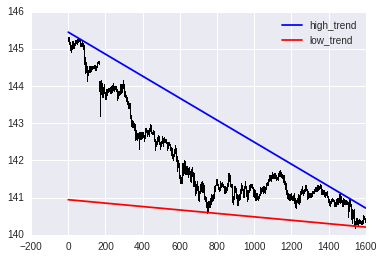

In [379]:
N = 1600
M = 0
dim=4

# prepare graph
fig = plt.figure()
ax = fig.add_subplot(111)

# focus on local data
high_data_mini = np.array(high_data[M:N])
low_data_mini = np.array(low_data[M:N])
df_mini = df[M:N]

# with AR model, smooth data
smoothed_high = smoothing(high_data_mini, dim=4)
smoothed_low = smoothing(low_data_mini, dim=4)

beg_end_list, high_line_list, low_line_list = get_line_data(df_mini)

candlestick2_ohlc(ax, ohlc_data["open"][M:N], ohlc_data["high"][M:N], 
                  ohlc_data["low"][M:N], ohlc_data["close"][M:N],
                 width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

n_data = len(df_mini)
high_trend = high_line_list[0][0] + (high_line_list[0][1] - high_line_list[0][0]) / n_data * np.arange(n_data)
low_trend = low_line_list[0][0] + (low_line_list[0][1] - low_line_list[0][0]) / n_data * np.arange(n_data)
ax.plot(high_trend, c='b', label='high_trend')
ax.plot(low_trend, c='r', label='low_trend')


ax.legend()

In [12]:
print (beg_end_list)
print (high_line_list)
print (low_line_list)

[[Timestamp('2015-01-02 08:00:00+0000', tz='UTC'), Timestamp('2015-01-09 21:15:00+0000', tz='UTC')]]
[[145.44762691127852, 140.71596437777904]]
[[140.94337276616369, 140.20636789611041]]
